# **Fine-Tuning BERT for Multi-Task Multi-Class Classification**
### *This notebook implements a pipeline to fine-tune a BERT model for classifying item descriptions into eBay and Vinted category labels. The pipeline includes data loading, visualization, preprocessing, tokenization, model training, and performance evaluation. The goal is to end up with a BERT model that accurately classifies the categories.*

## **Setting Up**
#### We begin by installing and importing the necessary libraries for model training, manipulation and evaluation.

In [ ]:
!pip install transformers torch scikit-learn pandas matplotlib joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 910.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
# Required libraries
import os
import json
import torch
import shutil
import joblib
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.optim import AdamW
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

#### To ensure consistent results across runs, we set a fixed random seed, allowing reproducible output.

In [ ]:
# Ensure reproducibility
random_seed = 115
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

## **Data loading, Preprocessing & Visualization**
#### We load in the dataset and encode the category labels using `LabelEncoder` to convert them into numerical values suitable for model training. The data is also split into training, validation, and test sets. We create visualizations  showcasing the number of unique categories per platform, the instance counts for each category across eBay and Vinted, and an illustration of the train-validation-test split proportions.

In [ ]:
!unzip bert_data.zip

Archive:  bert_data.zip
  inflating: Item Text-Category.csv  


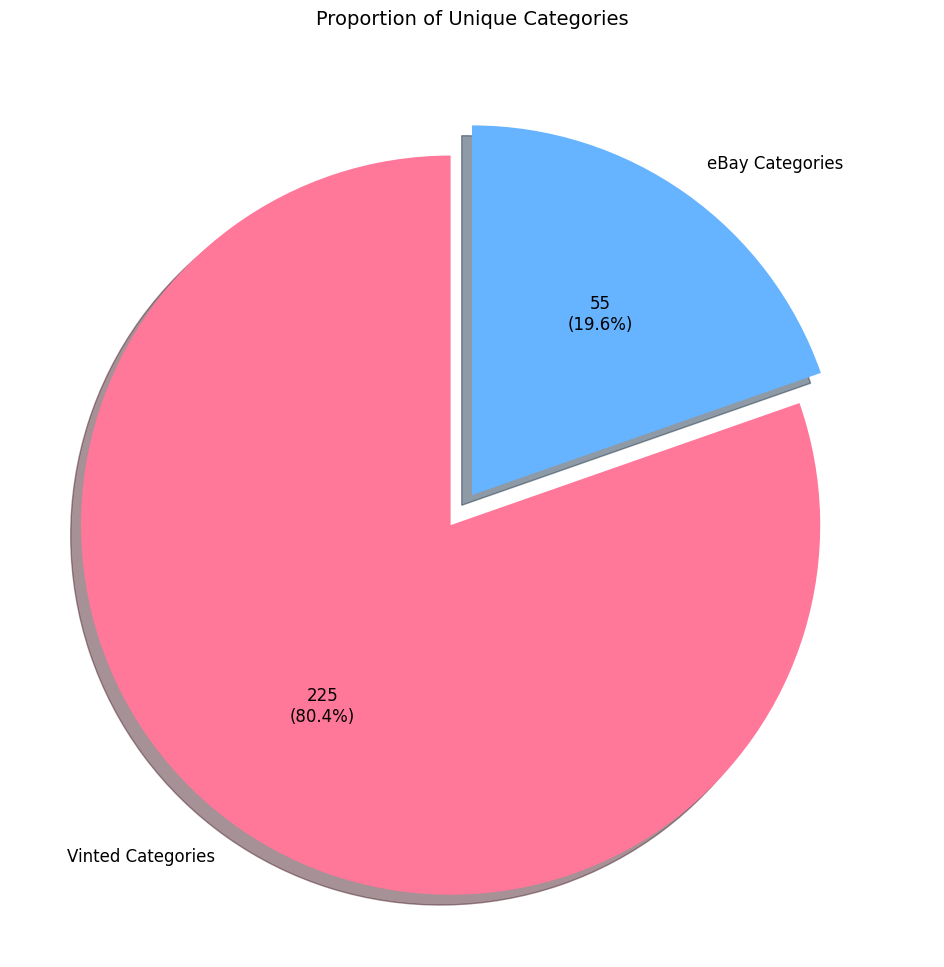

In [ ]:
# Read data
data = pd.read_csv("Item Text-Category.csv", header=0)

# Encode Vinted & eBay categories
vinted_encoder = LabelEncoder()
data['Vinted Label'] = vinted_encoder.fit_transform(data['Vinted Category'])

ebay_encoder = LabelEncoder()
data['eBay Label'] = ebay_encoder.fit_transform(data['eBay Category'])

# Train-validation-test split
train_data, val_test_data = train_test_split(data, test_size=0.2, random_state=random_seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=random_seed)

# Check unique categories
vinted_classes = data['Vinted Category'].unique()
ebay_classes = data['eBay Category'].unique()
vinted_count = len(vinted_classes)
ebay_count = len(ebay_classes)

# Data for the pie chart
labels = ['Vinted Categories', 'eBay Categories']
sizes = [vinted_count, ebay_count]
colors = ['#ff7799', '#66b3ff']
explode = (0.1, 0)

# Custom function to display count and percentage
def autopct_format(pct, allvals):
    count = int(round(pct/100 * sum(allvals)))
    return f"{count}\n({pct:.1f}%)"

# Plot pie chart
plt.figure(figsize=(15, 12))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes),
        startangle=90, shadow=True, textprops={'fontsize': 12})
plt.title('Proportion of Unique Categories', fontsize=14)
plt.savefig("Unique Categories.png")
plt.show()

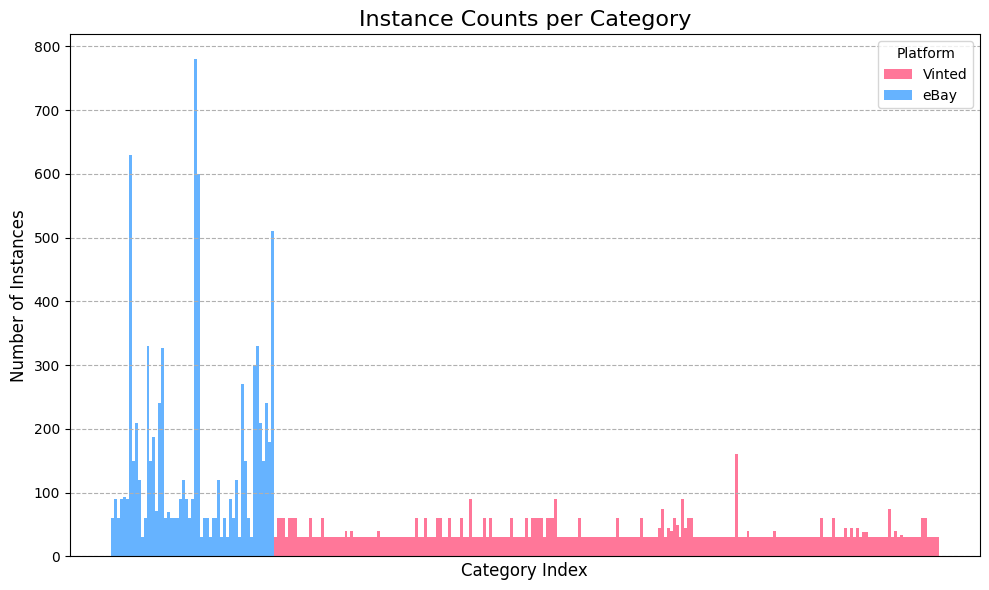

In [ ]:
# Get instance counts for Vinted and eBay categories
vinted_counts = data['Vinted Category'].value_counts().reset_index()
vinted_counts.columns = ['Category', 'Vinted Count']
ebay_counts = data['eBay Category'].value_counts().reset_index()
ebay_counts.columns = ['Category', 'eBay Count']

# Create side-by-side bar plot
plt.figure(figsize=(10, 6))

merged_counts = pd.merge(vinted_counts, ebay_counts, on='Category', how='outer').fillna(0)
x = range(len(merged_counts))

# Plot Vinted bars
bars_vinted = plt.bar(x, merged_counts['Vinted Count'], width=1 ,label='Vinted', color='#ff7799')

# Plot eBay bars
bars_ebay = plt.bar(x, merged_counts['eBay Count'], width=1, label='eBay', color='#66b3ff')

plt.xlabel('Category Index', fontsize=12)
plt.ylabel('Number of Instances', fontsize=12)
plt.title('Instance Counts per Category', fontsize=16)

plt.xticks([])
plt.legend(title='Platform', fontsize=10)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig("Instance Counts per Category.png")
plt.show()

In [ ]:
# Calculate total number of instances
total = len(data)
# Get value counts for eBay categories
ebay_value_counts = data['eBay Category'].value_counts()

# Get the most frequent eBay category
most_frequent_ebay_category = ebay_value_counts.idxmax()
most_frequent_ebay_count = ebay_value_counts.max()
most_frequent_ebay_percentage = (most_frequent_ebay_count / total) * 100

print("\n\033[1mTop 10 eBay Categories:\033[0m\n\n")

for category, count in ebay_value_counts.head(10).items():
    percentage = (count / total) * 100
    print(f"\033[1m{category}:\033[0m {count} ({percentage:.2f}%)\n")

# Get value counts for Vinted categories
vinted_value_counts = data['Vinted Category'].value_counts()

# Get the most frequent Vinted category
most_frequent_vinted_category = vinted_value_counts.idxmax()
most_frequent_vinted_count = vinted_value_counts.max()
most_frequent_vinted_percentage = (most_frequent_vinted_count / total) * 100

print("\n\n\033[1mTop 10 Vinted Categories:\033[0m\n\n")

for category, count in vinted_value_counts.head(10).items():
    percentage = (count / total) * 100
    print(f"\033[1m{category}:\033[0m {count} ({percentage:.2f}%)\n")


Top 10 eBay Categories:


Clothing, Shoes & Accessories > Women > Women's Clothing > Coats, Jackets & Vests: 780 (9.29%)

Clothing, Shoes & Accessories > Men > Men's Clothing > Coats, Jackets & Vests: 630 (7.50%)

Clothing, Shoes & Accessories > Women > Women's Clothing > Dresses: 600 (7.14%)

Clothing, Shoes & Accessories > Women > Women's Clothing > Tops: 510 (6.07%)

Clothing, Shoes & Accessories > Women > Women's Clothing > Shorts: 330 (3.93%)

Clothing, Shoes & Accessories > Men > Men's Clothing > Shirts > T-Shirts: 330 (3.93%)

Clothing, Shoes & Accessories > Men > Men's Clothing > Sweaters: 327 (3.89%)

Clothing, Shoes & Accessories > Women > Women's Clothing > Pants: 300 (3.57%)

Clothing, Shoes & Accessories > Women > Women's Clothing > Jeans: 270 (3.21%)

Clothing, Shoes & Accessories > Men > Men's Clothing > Suits & Suit Separates: 240 (2.86%)



Top 10 Vinted Categories:


Women > Clothing > Other clothing: 160 (1.90%)

Men > Clothing > Tops & t-shirts > Shirts > Other shi

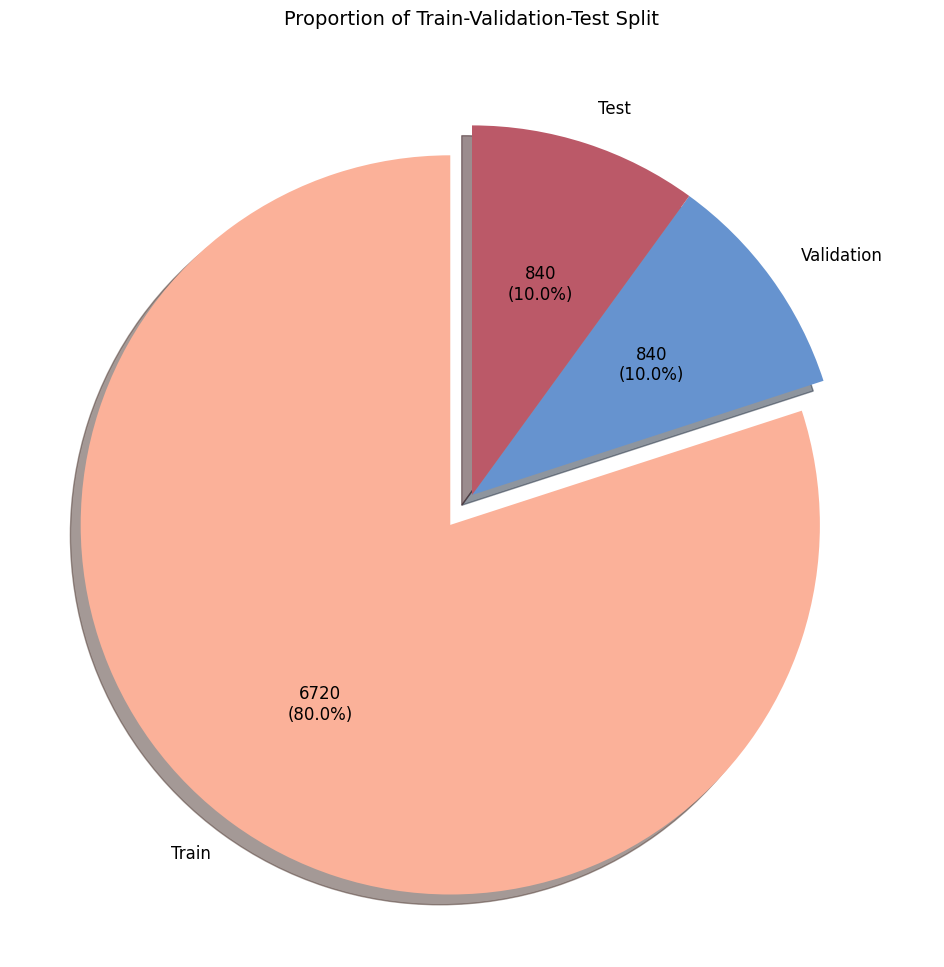

In [ ]:
# Train-validation-test split
train_data, val_test_data = train_test_split(data, test_size=0.2, random_state=random_seed)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=random_seed)

# Train-validation-test split sizes
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)

# Data for the pie chart
labels = ['Train', 'Validation', 'Test']
sizes = [train_size, val_size, test_size]
colors = ['#fbb199', '#6693cf', '#bb5968']
explode = (0.1, 0, 0)

# Custom function to display count and percentage
def autopct_format(pct, allvals):
    count = int(round(pct/100 * sum(allvals)))
    return f"{count}\n({pct:.1f}%)"

# Plot pie chart
plt.figure(figsize=(15, 12))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=lambda pct: autopct_format(pct, sizes),
        startangle=90, shadow=True, textprops={'fontsize': 12})
plt.title('Proportion of Train-Validation-Test Split', fontsize=14)
plt.savefig("Train Test Val Split.png")
plt.show()

## **Fine-Tuning Process**

#### We start off preparing the data for BERT by tokenizing item descriptions using the `BertTokenizer`. The custom `CategoryDataset` class handles the tokenized data and labels.

In [ ]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize function
def tokenize_data(data, max_length=32):
    encodings = tokenizer(
        data['Item Description'].tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'vinted_labels': torch.tensor(data['Vinted Label'].values),
        'ebay_labels': torch.tensor(data['eBay Label'].values)
    }

# Tokenize datasets
tokenized_train_data = tokenize_data(train_data)
tokenized_val_data = tokenize_data(val_data)
tokenized_test_data = tokenize_data(test_data)

# Define dataset class
class CategoryDataset(Dataset):
    def __init__(self, data):
        self.input_ids = data['input_ids']
        self.attention_mask = data['attention_mask']
        self.vinted_labels = data['vinted_labels']
        self.ebay_labels = data['ebay_labels']

    def __len__(self):
        return len(self.vinted_labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'vinted_labels': self.vinted_labels[idx],
            'ebay_labels': self.ebay_labels[idx]
        }

# Create datasets
train_dataset = CategoryDataset(tokenized_train_data)
val_dataset = CategoryDataset(tokenized_val_data)
test_dataset = CategoryDataset(tokenized_test_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### We define a custom `BertForMultiTaskClassification` model that extends BERT with two separate classification heads for Vinted and eBay categories. The model uses the [CLS] token embedding from BERT, applies dropout, and passes the output through two seperate linear layers to predict category logits for both platforms.

In [ ]:
# Define model
class BertForMultiTaskClassification(nn.Module):
    def __init__(self, num_vinted_classes, num_ebay_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.vinted_classifier = nn.Linear(768, num_vinted_classes)
        self.ebay_classifier = nn.Linear(768, num_ebay_classes)

    def forward(self, input_ids, attention_mask, vinted_labels=None, ebay_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # [CLS] token embedding
        pooled_output = self.dropout(pooled_output)

        vinted_logits = self.vinted_classifier(pooled_output)
        ebay_logits = self.ebay_classifier(pooled_output)

        loss = None
        if vinted_labels is not None and ebay_labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            vinted_loss = loss_fn(vinted_logits, vinted_labels)
            ebay_loss = loss_fn(ebay_logits, ebay_labels)
            loss = vinted_loss + ebay_loss  # Combine losses

        return {'loss': loss, 'vinted_logits': vinted_logits, 'ebay_logits': ebay_logits}

#### We set up `DataLoader` objects for efficient batch processing during training, validation, and testing. The BERT model is initialized and the first six layers are frozen to hold their original values during fine-tuning. This not only reduces computational load, but also ensures that the lower level linguistic pattern understading of the original model is maintained. We choose our training hyperparameters here.

In [ ]:
# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = BertForMultiTaskClassification(vinted_count, ebay_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Freeze the first 6 layers of BERT
for layer in model.bert.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False

# Training hyperparameters
epochs = 23
learning_rate = 2e-5
total_steps = len(train_loader) * epochs
warmup_steps = int(0.1 * total_steps)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

#### Next, we define the functions for training and evaluating the model:
#### **`train_epoch`**: Trains the model for one epoch, computing the combined loss for Vinted and eBay classification tasks and updating model parameters using the optimizer and scheduler.
#### **`evaluate`**: Evaluates the model on a given dataset, computing micro-, macro-, and weighted-averaged precision, recall, F1-score, and accuracy for both Vinted and eBay predictions.

In [ ]:
# Training function
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        vinted_labels = batch['vinted_labels'].to(device)
        ebay_labels = batch['ebay_labels'].to(device)

        outputs = model(input_ids, attention_mask, vinted_labels, ebay_labels)
        loss = outputs['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation function
def evaluate(model, loader):
    model.eval()
    vinted_preds, vinted_true = [], []
    ebay_preds, ebay_true = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            vinted_labels = batch['vinted_labels'].to(device)
            ebay_labels = batch['ebay_labels'].to(device)

            outputs = model(input_ids, attention_mask, vinted_labels, ebay_labels)
            loss = outputs['loss']
            total_loss += loss.item()

            vinted_logits = outputs['vinted_logits'].cpu().numpy()
            ebay_logits = outputs['ebay_logits'].cpu().numpy()
            vinted_preds.extend(np.argmax(vinted_logits, axis=1))
            ebay_preds.extend(np.argmax(ebay_logits, axis=1))
            vinted_true.extend(vinted_labels.cpu().numpy())
            ebay_true.extend(ebay_labels.cpu().numpy())

    # Compute micro-averaged metrics
    vinted_precision_micro, vinted_recall_micro, vinted_f1_micro, _ = precision_recall_fscore_support(
        vinted_true, vinted_preds, average='micro', zero_division=0
    )
    ebay_precision_micro, ebay_recall_micro, ebay_f1_micro, _ = precision_recall_fscore_support(
        ebay_true, ebay_preds, average='micro', zero_division=0
    )

    # Compute macro-averaged metrics
    vinted_precision_macro, vinted_recall_macro, vinted_f1_macro, _ = precision_recall_fscore_support(
        vinted_true, vinted_preds, average='macro', zero_division=0
    )
    ebay_precision_macro, ebay_recall_macro, ebay_f1_macro, _ = precision_recall_fscore_support(
        ebay_true, ebay_preds, average='macro', zero_division=0
    )

    # Compute weighted-averaged metrics
    vinted_precision_weighted, vinted_recall_weighted, vinted_f1_weighted, _ = precision_recall_fscore_support(
        vinted_true, vinted_preds, average='weighted', zero_division=0
    )
    ebay_precision_weighted, ebay_recall_weighted, ebay_f1_weighted, _ = precision_recall_fscore_support(
        ebay_true, ebay_preds, average='weighted', zero_division=0
    )

    # Compute accuracy
    vinted_accuracy = accuracy_score(vinted_true, vinted_preds)
    ebay_accuracy = accuracy_score(ebay_true, ebay_preds)

    return {
        'loss': total_loss / len(loader),
        'vinted_precision_micro': vinted_precision_micro,
        'vinted_recall_micro': vinted_recall_micro,
        'vinted_f1_micro': vinted_f1_micro,
        'vinted_precision_macro': vinted_precision_macro,
        'vinted_recall_macro': vinted_recall_macro,
        'vinted_f1_macro': vinted_f1_macro,
        'vinted_precision_weighted': vinted_precision_weighted,
        'vinted_recall_weighted': vinted_recall_weighted,
        'vinted_f1_weighted': vinted_f1_weighted,
        'vinted_accuracy': vinted_accuracy,
        'ebay_precision_micro': ebay_precision_micro,
        'ebay_recall_micro': ebay_recall_micro,
        'ebay_f1_micro': ebay_f1_micro,
        'ebay_precision_macro': ebay_precision_macro,
        'ebay_recall_macro': ebay_recall_macro,
        'ebay_f1_macro': ebay_f1_macro,
        'ebay_precision_weighted': ebay_precision_weighted,
        'ebay_recall_weighted': ebay_recall_weighted,
        'ebay_f1_weighted': ebay_f1_weighted,
        'ebay_accuracy': ebay_accuracy
    }

#### The training loop runs for the specified number of epochs and tracks training and validation losses, as well as performance metrics for both Vinted and eBay. The best model, based on validation loss, is saved, along with the label encoders and model configuration.

In [ ]:
# Create save directory
save_dir = '/bert_category_classifier_complete'
os.makedirs(save_dir, exist_ok=True)

# Initialize lists to store metrics
train_losses = []
val_losses = []
vinted_metrics = {
    'precision_micro': [], 'recall_micro': [], 'f1_micro': [],
    'precision_macro': [], 'recall_macro': [], 'f1_macro': [],
    'precision_weighted': [], 'recall_weighted': [], 'f1_weighted': [],
    'accuracy': []
}
ebay_metrics = {
    'precision_micro': [], 'recall_micro': [], 'f1_micro': [],
    'precision_macro': [], 'recall_macro': [], 'f1_macro': [],
    'precision_weighted': [], 'recall_weighted': [], 'f1_weighted': [],
    'accuracy': []
}

# Best model tracking parameters
best_epoch = 0
best_val_loss = float('inf')
model_save_path = f'{save_dir}/best_bert_category_classifier.pth'

# Training loop
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    val_metrics = evaluate(model, val_loader)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_metrics['loss'])
    vinted_metrics['precision_micro'].append(val_metrics['vinted_precision_micro'])
    vinted_metrics['recall_micro'].append(val_metrics['vinted_recall_micro'])
    vinted_metrics['f1_micro'].append(val_metrics['vinted_f1_micro'])
    vinted_metrics['precision_macro'].append(val_metrics['vinted_precision_macro'])
    vinted_metrics['recall_macro'].append(val_metrics['vinted_recall_macro'])
    vinted_metrics['f1_macro'].append(val_metrics['vinted_f1_macro'])
    vinted_metrics['precision_weighted'].append(val_metrics['vinted_precision_weighted'])
    vinted_metrics['recall_weighted'].append(val_metrics['vinted_recall_weighted'])
    vinted_metrics['f1_weighted'].append(val_metrics['vinted_f1_weighted'])
    vinted_metrics['accuracy'].append(val_metrics['vinted_accuracy'])
    ebay_metrics['precision_micro'].append(val_metrics['ebay_precision_micro'])
    ebay_metrics['recall_micro'].append(val_metrics['ebay_recall_micro'])
    ebay_metrics['f1_micro'].append(val_metrics['ebay_f1_micro'])
    ebay_metrics['precision_macro'].append(val_metrics['ebay_precision_macro'])
    ebay_metrics['recall_macro'].append(val_metrics['ebay_recall_macro'])
    ebay_metrics['f1_macro'].append(val_metrics['ebay_f1_macro'])
    ebay_metrics['precision_weighted'].append(val_metrics['ebay_precision_weighted'])
    ebay_metrics['recall_weighted'].append(val_metrics['ebay_recall_weighted'])
    ebay_metrics['f1_weighted'].append(val_metrics['ebay_f1_weighted'])
    ebay_metrics['accuracy'].append(val_metrics['ebay_accuracy'])

    # Print epoch results
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_metrics['loss']:.4f}")
    print(f"Vinted (Micro): Precision={val_metrics['vinted_precision_micro']:.4f}, Recall={val_metrics['vinted_recall_micro']:.4f}, F1-Score={val_metrics['vinted_f1_micro']:.4f}, Accuracy={val_metrics['vinted_accuracy']:.4f}")
    print(f"Vinted (Macro): Precision={val_metrics['vinted_precision_macro']:.4f}, Recall={val_metrics['vinted_recall_macro']:.4f}, F1-Score={val_metrics['vinted_f1_macro']:.4f}")
    print(f"Vinted (Weighted): Precision={val_metrics['vinted_precision_weighted']:.4f}, Recall={val_metrics['vinted_recall_weighted']:.4f}, F1-Score={val_metrics['vinted_f1_weighted']:.4f}")
    print(f"eBay (Micro): Precision={val_metrics['ebay_precision_micro']:.4f}, Recall={val_metrics['ebay_recall_micro']:.4f}, F1-Score={val_metrics['ebay_f1_micro']:.4f}, Accuracy={val_metrics['ebay_accuracy']:.4f}")
    print(f"eBay (Macro): Precision={val_metrics['ebay_precision_macro']:.4f}, Recall={val_metrics['ebay_recall_macro']:.4f}, F1-Score={val_metrics['ebay_f1_macro']:.4f}")
    print(f"eBay (Weighted): Precision={val_metrics['ebay_precision_weighted']:.4f}, Recall={val_metrics['ebay_recall_weighted']:.4f}, F1-Score={val_metrics['ebay_f1_weighted']:.4f}\n")

    # Save best model
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        best_epoch = epoch + 1
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved best model at epoch {best_epoch} with validation loss: {best_val_loss:.4f}\n")
    else:
        print(f"No improvement in validation loss for this epoch\n")

Epoch 1: Train Loss: 9.0564, Val Loss: 7.9793
Vinted (Micro): Precision=0.0119, Recall=0.0119, F1-Score=0.0119, Accuracy=0.0119
Vinted (Macro): Precision=0.0017, Recall=0.0130, F1-Score=0.0027
Vinted (Weighted): Precision=0.0023, Recall=0.0119, F1-Score=0.0036
eBay (Micro): Precision=0.4524, Recall=0.4524, F1-Score=0.4524, Accuracy=0.4524
eBay (Macro): Precision=0.1128, Recall=0.1556, F1-Score=0.1152
eBay (Weighted): Precision=0.2789, Recall=0.4524, F1-Score=0.3260

Saved best model at epoch 1 with validation loss: 7.9793
Epoch 2: Train Loss: 6.7153, Val Loss: 5.1801
Vinted (Micro): Precision=0.2679, Recall=0.2679, F1-Score=0.2679, Accuracy=0.2679
Vinted (Macro): Precision=0.1133, Recall=0.1902, F1-Score=0.1193
Vinted (Weighted): Precision=0.1726, Recall=0.2679, F1-Score=0.1780
eBay (Micro): Precision=0.7940, Recall=0.7940, F1-Score=0.7940, Accuracy=0.7940
eBay (Macro): Precision=0.4912, Recall=0.4971, F1-Score=0.4625
eBay (Weighted): Precision=0.7108, Recall=0.7940, F1-Score=0.7305

S

#### After training has completed, we load in the best model and evaluate its performance on the unseen test set. We report micro-, macro-, and weighted-averaged precision, recall, F1-score, and accuracy.

In [ ]:
# Load the best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Evaluate on test set
test_metrics = evaluate(model, test_loader)

# Print test metrics
print("Test Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
print("\n--- Vinted Metrics ---")
print(f"Accuracy: {test_metrics['vinted_accuracy']:.4f}")
print(f"  Micro-averaged: Precision={test_metrics['vinted_precision_micro']:.4f}, Recall={test_metrics['vinted_recall_micro']:.4f}, F1-Score={test_metrics['vinted_f1_micro']:.4f}")
print(f"  Macro-averaged: Precision={test_metrics['vinted_precision_macro']:.4f}, Recall={test_metrics['vinted_recall_macro']:.4f}, F1-Score={test_metrics['vinted_f1_macro']:.4f}")
print(f"  Weighted-averaged: Precision={test_metrics['vinted_precision_weighted']:.4f}, Recall={test_metrics['vinted_recall_weighted']:.4f}, F1-Score={test_metrics['vinted_f1_weighted']:.4f}")

print("\n--- eBay Metrics ---")
print(f"Accuracy: {test_metrics['ebay_accuracy']:.4f}")
print(f"  Micro-averaged: Precision={test_metrics['ebay_precision_micro']:.4f}, Recall={test_metrics['ebay_recall_micro']:.4f}, F1-Score={test_metrics['ebay_f1_micro']:.4f}")
print(f"  Macro-averaged: Precision={test_metrics['ebay_precision_macro']:.4f}, Recall={test_metrics['ebay_recall_macro']:.4f}, F1-Score={test_metrics['ebay_f1_macro']:.4f}")
print(f"  Weighted-averaged: Precision={test_metrics['ebay_precision_weighted']:.4f}, Recall={test_metrics['ebay_recall_weighted']:.4f}, F1-Score={test_metrics['ebay_f1_weighted']:.4f}")

Test Metrics:
Loss: 0.0986

--- Vinted Metrics ---
Accuracy: 0.9738
  Micro-averaged: Precision=0.9738, Recall=0.9738, F1-Score=0.9738
  Macro-averaged: Precision=0.9648, Recall=0.9657, F1-Score=0.9633
  Weighted-averaged: Precision=0.9724, Recall=0.9738, F1-Score=0.9710

--- eBay Metrics ---
Accuracy: 0.9964
  Micro-averaged: Precision=0.9964, Recall=0.9964, F1-Score=0.9964
  Macro-averaged: Precision=0.9981, Recall=0.9987, F1-Score=0.9984
  Weighted-averaged: Precision=0.9966, Recall=0.9964, F1-Score=0.9964


#### We save the original pretrained model, our category label encoders, and model configuration to a directory, and then create a zip file for easy downloading. This way we can easily load and use our trained model anywhere.

In [ ]:
# Save label encoders
joblib.dump(vinted_encoder, f'{save_dir}/vinted_encoder.pkl')
joblib.dump(ebay_encoder, f'{save_dir}/ebay_encoder.pkl')

# Save number of classes
config = {
    'num_vinted_classes': vinted_count,
    'num_ebay_classes': ebay_count
}
with open(f'{save_dir}/model_config.json', 'w') as f:
    json.dump(config, f)

# Save BERT model and tokenizer
model.bert.save_pretrained(f'{save_dir}/bert_category_classifier')
tokenizer.save_pretrained(f'{save_dir}/bert_category_classifier')

# Create zip file
shutil.make_archive('bert_category_classifier_complete', 'zip', save_dir)

'/content/bert_category_classifier_complete.zip'

In [ ]:
# Download the zipped file (ATTENTION: Saves full model ZIP (~1GB) to local pc)
from google.colab import files
files.download('/content/bert_category_classifier_complete.zip')

#### We finish by plotting the training and validation loss, as well as the other performance metrics across all epochs. These visualizations help assess the model's performance over time and we can compare training on the two platforms.

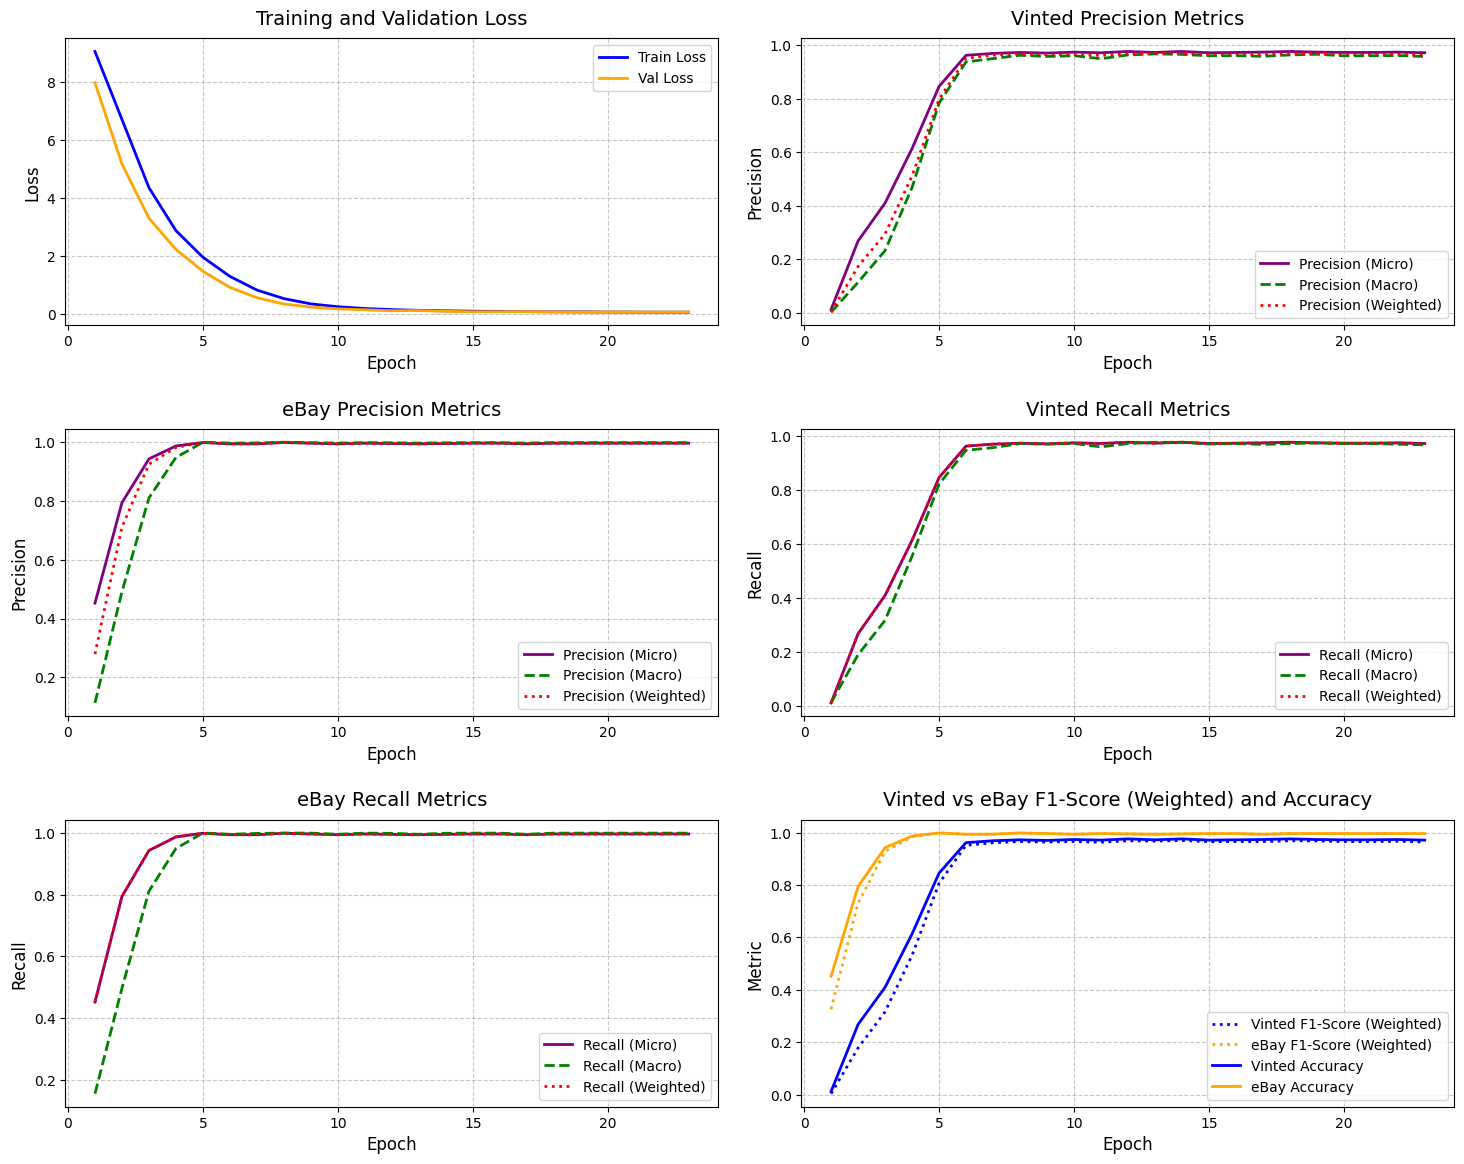

In [ ]:
# Plot all metrics
plt.figure(figsize=(15, 12))

# Plot 1: Training and Validation Loss
plt.subplot(3, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss', color='orange', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Precision Vinted
plt.subplot(3, 2, 2)
plt.plot(range(1, len(vinted_metrics['precision_micro'])+1), vinted_metrics['precision_micro'], label='Precision (Micro)', color='purple', linestyle='-', linewidth=2)
plt.plot(range(1, len(vinted_metrics['precision_macro'])+1), vinted_metrics['precision_macro'], label='Precision (Macro)', color='green', linestyle='--', linewidth=2)
plt.plot(range(1, len(vinted_metrics['precision_weighted'])+1), vinted_metrics['precision_weighted'], label='Precision (Weighted)', color='red', linestyle=':', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Vinted Precision Metrics', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 3: Precision eBay
plt.subplot(3, 2, 3)
plt.plot(range(1, len(ebay_metrics['precision_micro'])+1), ebay_metrics['precision_micro'], label='Precision (Micro)', color='purple', linestyle='-', linewidth=2)
plt.plot(range(1, len(ebay_metrics['precision_macro'])+1), ebay_metrics['precision_macro'], label='Precision (Macro)', color='green', linestyle='--', linewidth=2)
plt.plot(range(1, len(ebay_metrics['precision_weighted'])+1), ebay_metrics['precision_weighted'], label='Precision (Weighted)', color='red', linestyle=':', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('eBay Precision Metrics', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 4: Recall Vinted
plt.subplot(3, 2, 4)
plt.plot(range(1, len(vinted_metrics['recall_micro'])+1), vinted_metrics['recall_micro'], label='Recall (Micro)', color='purple', linestyle='-', linewidth=2)
plt.plot(range(1, len(vinted_metrics['recall_macro'])+1), vinted_metrics['recall_macro'], label='Recall (Macro)', color='green', linestyle='--', linewidth=2)
plt.plot(range(1, len(vinted_metrics['recall_weighted'])+1), vinted_metrics['recall_weighted'], label='Recall (Weighted)', color='red', linestyle=':', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Vinted Recall Metrics', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 5: Recall eBay
plt.subplot(3, 2, 5)
plt.plot(range(1, len(ebay_metrics['recall_micro'])+1), ebay_metrics['recall_micro'], label='Recall (Micro)', color='purple', linestyle='-', linewidth=2)
plt.plot(range(1, len(ebay_metrics['recall_macro'])+1), ebay_metrics['recall_macro'], label='Recall (Macro)', color='green', linestyle='--', linewidth=2)
plt.plot(range(1, len(ebay_metrics['recall_weighted'])+1), ebay_metrics['recall_weighted'], label='Recall (Weighted)', color='red', linestyle=':', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('eBay Recall Metrics', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 6: Vinted vs eBay Metrics (F1-Score and Accuracy)
plt.subplot(3, 2, 6)
plt.plot(range(1, len(vinted_metrics['f1_weighted'])+1), vinted_metrics['f1_weighted'], label='Vinted F1-Score (Weighted)', color='blue', linestyle=':', linewidth=2)
plt.plot(range(1, len(ebay_metrics['f1_weighted'])+1), ebay_metrics['f1_weighted'], label='eBay F1-Score (Weighted)', color='orange', linestyle=':', linewidth=2)
plt.plot(range(1, len(vinted_metrics['accuracy'])+1), vinted_metrics['accuracy'], label='Vinted Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, len(ebay_metrics['accuracy'])+1), ebay_metrics['accuracy'], label='eBay Accuracy', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Metric', fontsize=12)
plt.title('Vinted vs eBay F1-Score (Weighted) and Accuracy', fontsize=14, pad=10)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(pad=2.0)
plt.savefig("BERT Results.png")
plt.show()